<a href="https://colab.research.google.com/github/wjdolan/DS_Portfolio/blob/main/ts_heterskedacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis: Heteroskedacity

In [10]:
#!pip install pmdarima

In [11]:
import pandas as pd
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import numpy as np

import matplotlib.pyplot as plt 

In [3]:
TEST_NAMES = ['White', 'Breusch-Pagan', 'Goldfeld-Quandt']
FORMULA = 'value ~ time'



In [4]:
class Heteroskedasticity:

    @staticmethod
    def het_tests(series: pd.Series, test: str) -> float:
        """
        Testing for heteroskedasticity

        :param series: Univariate time series as pd.Series
        :param test: String denoting the test. One of 'white','goldfeldquandt', or 'breuschpagan'

        :return: p-value as a float.

        If the p-value is high, we accept the null hypothesis that the data is homoskedastic
        """
        assert test in TEST_NAMES, 'Unknown test'

        series = series.reset_index(drop=True).reset_index()
        series.columns = ['time', 'value']
        series['time'] += 1

        olsr = ols(FORMULA, series).fit()

        if test == 'White':
            _, p_value, _, _ = sms.het_white(olsr.resid, olsr.model.exog)
        elif test == 'Goldfeld-Quandt':
            _, p_value, _ = sms.het_goldfeldquandt(olsr.resid, olsr.model.exog, alternative='two-sided')
        else:
            _, p_value, _, _ = sms.het_breuschpagan(olsr.resid, olsr.model.exog)

        return p_value

    @classmethod
    def run_all_tests(cls, series: pd.Series):

        test_results = {k: cls.het_tests(series, k) for k in TEST_NAMES}

        return test_results



In [19]:
from pmdarima.datasets import load_airpassengers

series = load_airpassengers(True)

test_results = Heteroskedasticity.run_all_tests(series)

# {'Breusch-Pagan': 4.55e-07,
# 'Goldfeld-Quandt': 8.81e-13,
# 'White': 4.34e-07}

In [6]:
print(test_results)

{'White': 4.3457544661286996e-07, 'Breusch-Pagan': 4.559001856883369e-07, 'Goldfeld-Quandt': 8.812950329262019e-13}


In [7]:
import numpy as np

test_results = Heteroskedasticity.run_all_tests(np.log(series))

In [8]:
print(test_results)

{'White': 0.10018100617380284, 'Breusch-Pagan': 0.0329267875956314, 'Goldfeld-Quandt': 0.18331567974365376}


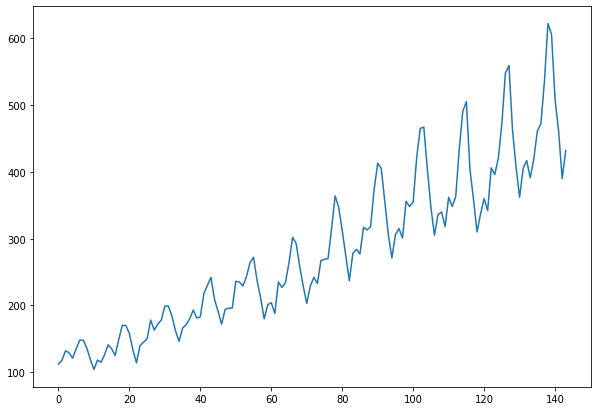

In [9]:
plt.figure(figsize=(10,7))

plt.plot(series.index, series.values)


In [12]:
log_series = np.log(series)

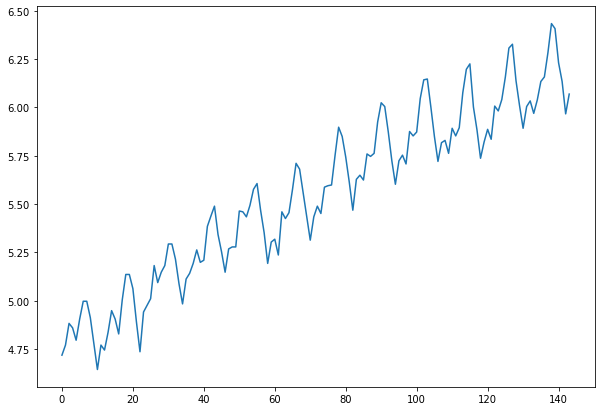

In [14]:
plt.figure(figsize=(10,7))

plt.plot(log_series.index, log_series.values)

In [15]:
from sklearn.model_selection import train_test_split as tts
from pmdarima.arima import auto_arima

# leave the last 12 points for testing
train, test = tts(series, test_size=12, shuffle=False)

# use stabilized variance for training
# build arima model where m is seasonal period

fitmodel = auto_arima(log_series, seasonal=True, m=12)

modpredict = fitmodel.predict(12)

# revert forecasts back to non log
forecasts = np.exp(modpredict)

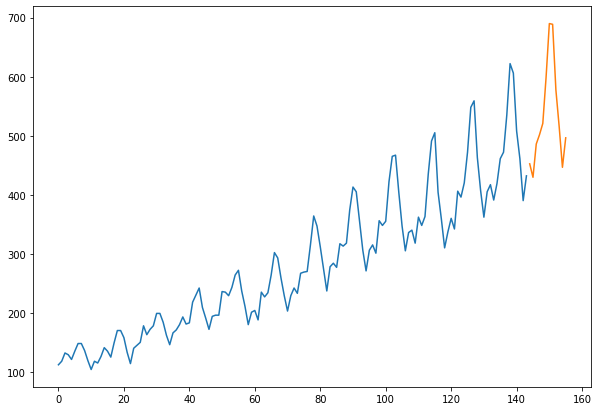

In [18]:
plt.figure(figsize=(10,7))
plt.plot(series.index, series.values)
plt.plot(forecasts.index, forecasts.values)